Attribute Information:

Car Name – Name of the car

Cyl – No of cylinders in the car – Multivalued discrete

Disp – Displacement – continuous

Hp – Horsepower – continuous

Wt – Weight – continuous

Acc – Accleration – continuous

Yr – Model of the car – Multivalued discrete

<h2> 1. EDA & Pre-processing (removed all non-numeric entries from numeric columns) 

In [83]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

cars = pd.read_csv("cars-dataset.csv", delim_whitespace = '')
cars.head(10)

,car name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150,3433,12.0,70,16.0
4,ford torino,8,302.0,140,3449,10.5,70,17.0
5,ford galaxie 500,8,429.0,198,4341,10.0,70,15.0
6,chevrolet impala,8,454.0,220,4354,9.0,70,14.0
7,plymouth fury iii,8,440.0,215,4312,8.5,70,14.0
8,pontiac catalina,8,455.0,225,4425,10.0,70,14.0
9,amc ambassador dpl,8,390.0,190,3850,8.5,70,15.0


In [84]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


In [85]:
missing_values=cars.columns[cars.isnull().any()]
cars[missing_values].isnull().sum()

Series([], dtype: float64)

<h3> Observation : There seems to be no null values but horsepower datatype is supossed to be in an integer type but it is an object hence we will look into the variable in detail

In [86]:
cars.hp.unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

<h3>Observation: There seems to be some question marks in horse power which should be treated with median value and converted into int data type

In [87]:
cars['hp'] = cars['hp'].replace('?',np.nan)
cars['hp'] = cars['hp'].fillna(cars['hp'].median()).astype('int64')

<h5> Car name will be droped from the analysis since it is not a strong predictor

In [88]:
cars.drop('car name',axis=1,inplace=True)

In [89]:
cars.sample(10)

,cyl,disp,hp,wt,acc,yr,mpg
327,5,121.0,67,2950,19.9,80,36.4
281,6,200.0,85,2990,18.2,79,19.8
119,4,114.0,91,2582,14.0,73,20.0
157,8,350.0,145,4440,14.0,75,15.0
165,8,262.0,110,3221,13.5,75,20.0
1,8,350.0,165,3693,11.5,70,15.0
54,4,72.0,69,1613,18.0,71,35.0
326,4,90.0,48,2335,23.7,80,43.4
320,4,119.0,92,2434,15.0,80,37.0
11,8,340.0,160,3609,8.0,70,14.0


<h2> 2. Using pair plot or scatter matrix to visualize how the different variables are related. The amount of Gaussian curves in the plot should give a visual identification of different clusters existing in the dataset.

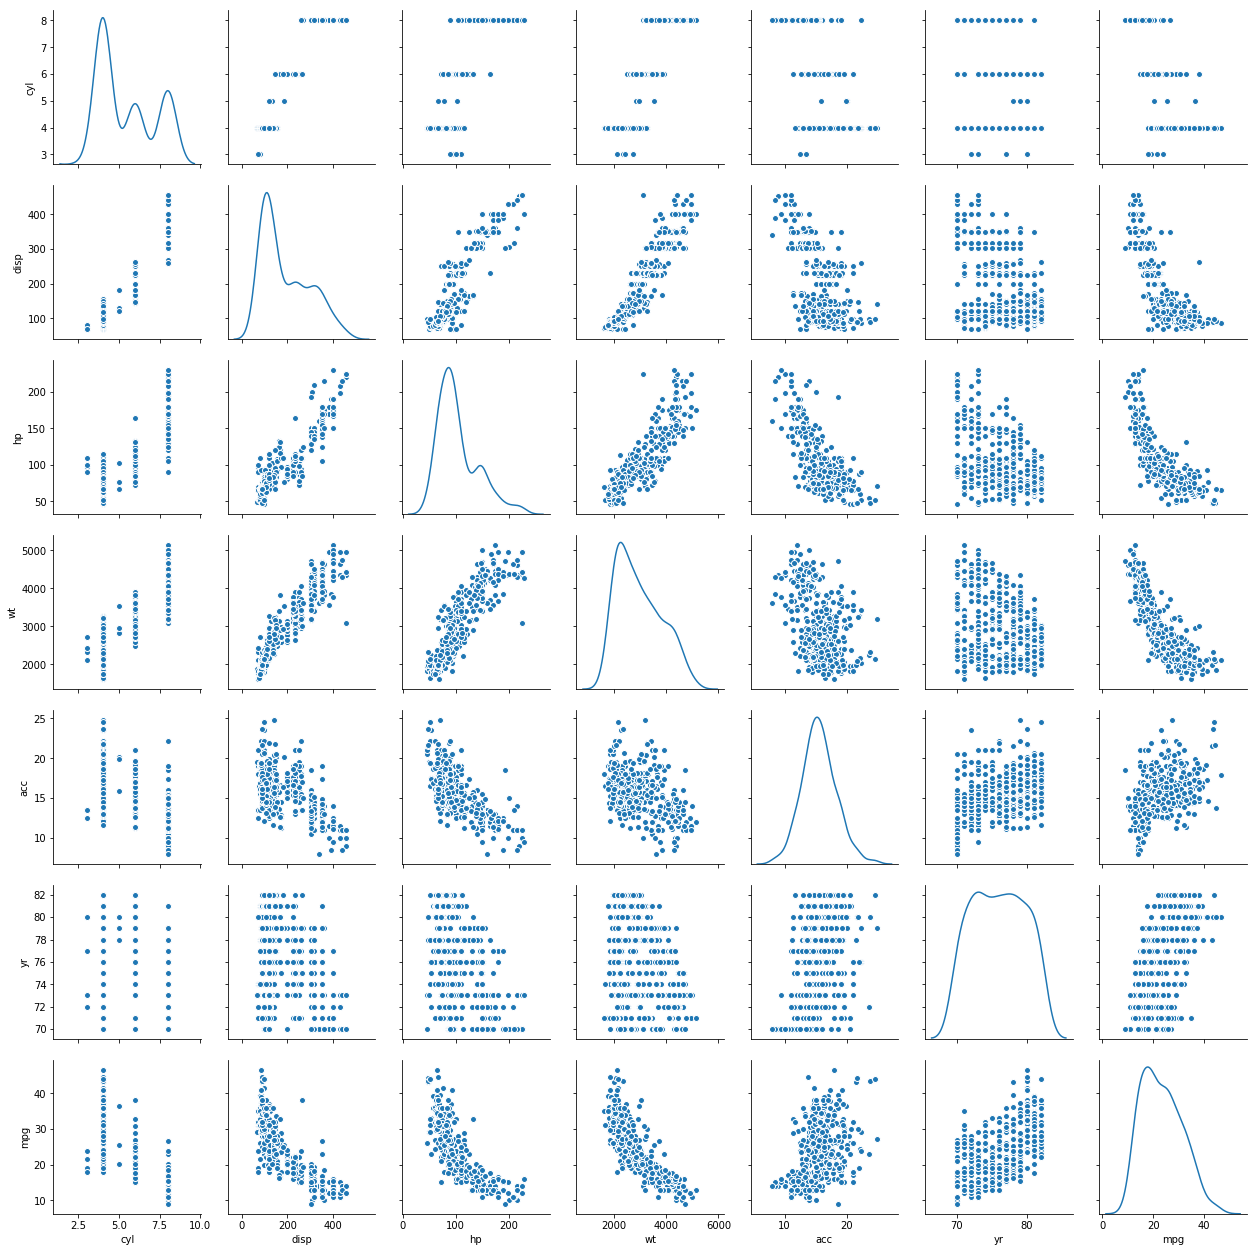

In [90]:
sns.pairplot(cars,diag_kind="kde")

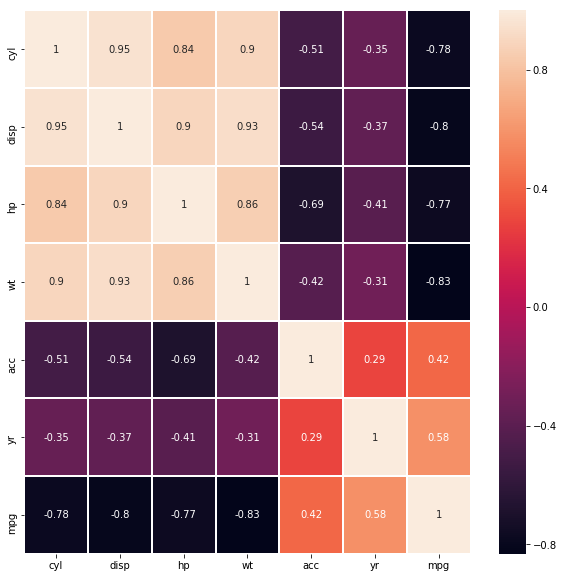

In [93]:
plt.subplots(figsize=(10,10))
sns.heatmap(cars.corr(), annot=True, linewidths=1)

<h2> From the pairplot we can conclude that cylinder has three clear gaussian, horsepower has two gaussian and displacement has three gaussian. 
<br>
We can conclude that it may have 3 to 6 clusters.

1. There seems to be positive correlation between horsepower - Weight, Horsepower - Displacement and Displacement - Weight.
2. There is a negative correlation between Displacement - Mpg, Mpg - Weight and Mpg - Horsepower.
3. Car with 4 cylinders has maximum Mpg.
4. There is a weak positive correlation between Accelaration - weight and Accelaration has a weak negative correlation between displacement, Horsepower and weight 

<h2> Featurization and Standaization is done on the above dataset 

<h3>  Year feature is transformed to calculate the age of the car by subtracting it from 83., thts the year this dataset was created 

In [125]:
cars['age']= 83 - cars['yr']

In [163]:
cars_edited = cars.copy(deep=True)

from scipy.stats import zscore

cars_z = cars.apply(zscore)

<h2> Above dataset is checked for outliers. 

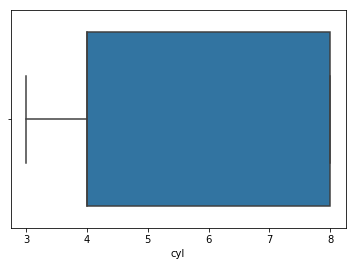

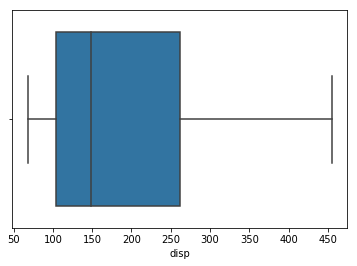

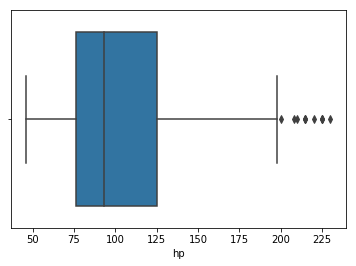

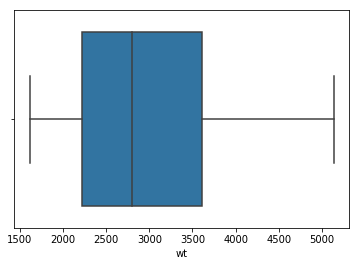

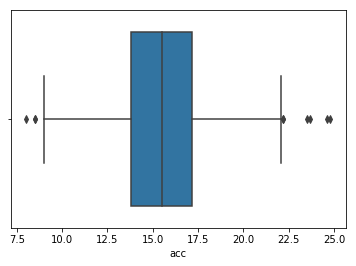

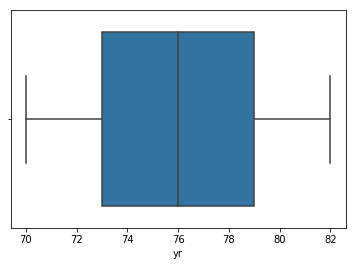

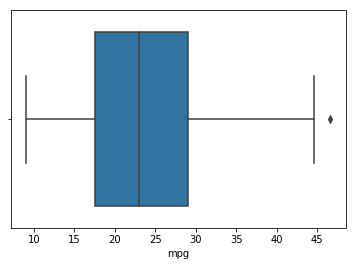

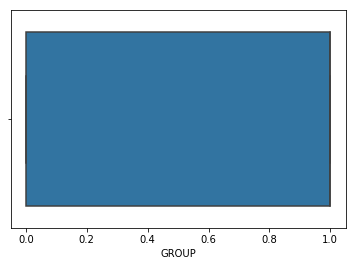

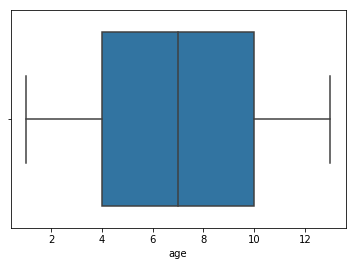

In [127]:
for i, col in enumerate(cars_z):
    plt.figure(i)
    sns.boxplot(cars[col])

<h3> Horsepower, acceleration and Mpg seems to have some outliers. Which will be treated after clusteres are created.

<h2> 3. Using K Means or Hierarchical clustering to find out the optimal no of clusters in the data. Identify and separate the clusters

In [172]:
from sklearn.cluster import KMeans


# Let us check optimal number of clusters-


cluster_range = range( 2, 7)   # expect 3 to six clusters from the pair panel visual inspection hence restricting from 2 to 6
cluster_errors = []
cluster_sil_scores = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 5)
  clusters.fit(cars_z)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_errors.append( clusters.inertia_ )    # capture the intertia
  


# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df[0:15]

,num_clusters,cluster_errors
0,2,1872.879666
1,3,1374.803656
2,4,940.720613
3,5,831.475723
4,6,736.083167


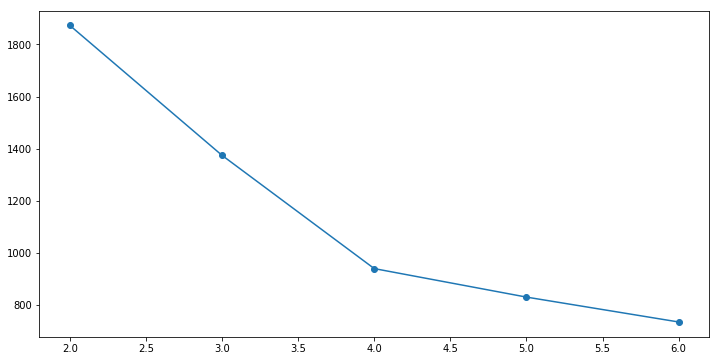

In [173]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

<h5> Elbow plot confirms our visual analysis that there are likely 3 or 5 good clusters

In [174]:
kmeans_2 = KMeans(n_clusters=3)
# Fitting the input data
kmeans_2 = kmeans_2.fit(cars_z)
# Centroid values
centroids_2 = kmeans_2.cluster_centers_
# Comparing with scikit-learn centroids
print("Centroid values")
print(centroids_2) # From sci-kit learn



Centroid values
[[ 0.56258261  0.46087712  0.07715749  0.48230519  0.2431918  -0.04547684
  -0.59478597  3.51578947  0.04547684]
 [-0.78738216 -0.76254135 -0.62532965 -0.73935015  0.31382433  0.34246734
   0.69953127  0.4009009  -0.34246734]
 [ 1.49819126  1.54939326  1.62337311  1.4607005  -1.14533608 -0.88527717
  -1.21964536  2.          0.88527717]]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000004291432400>,
      dtype=object)

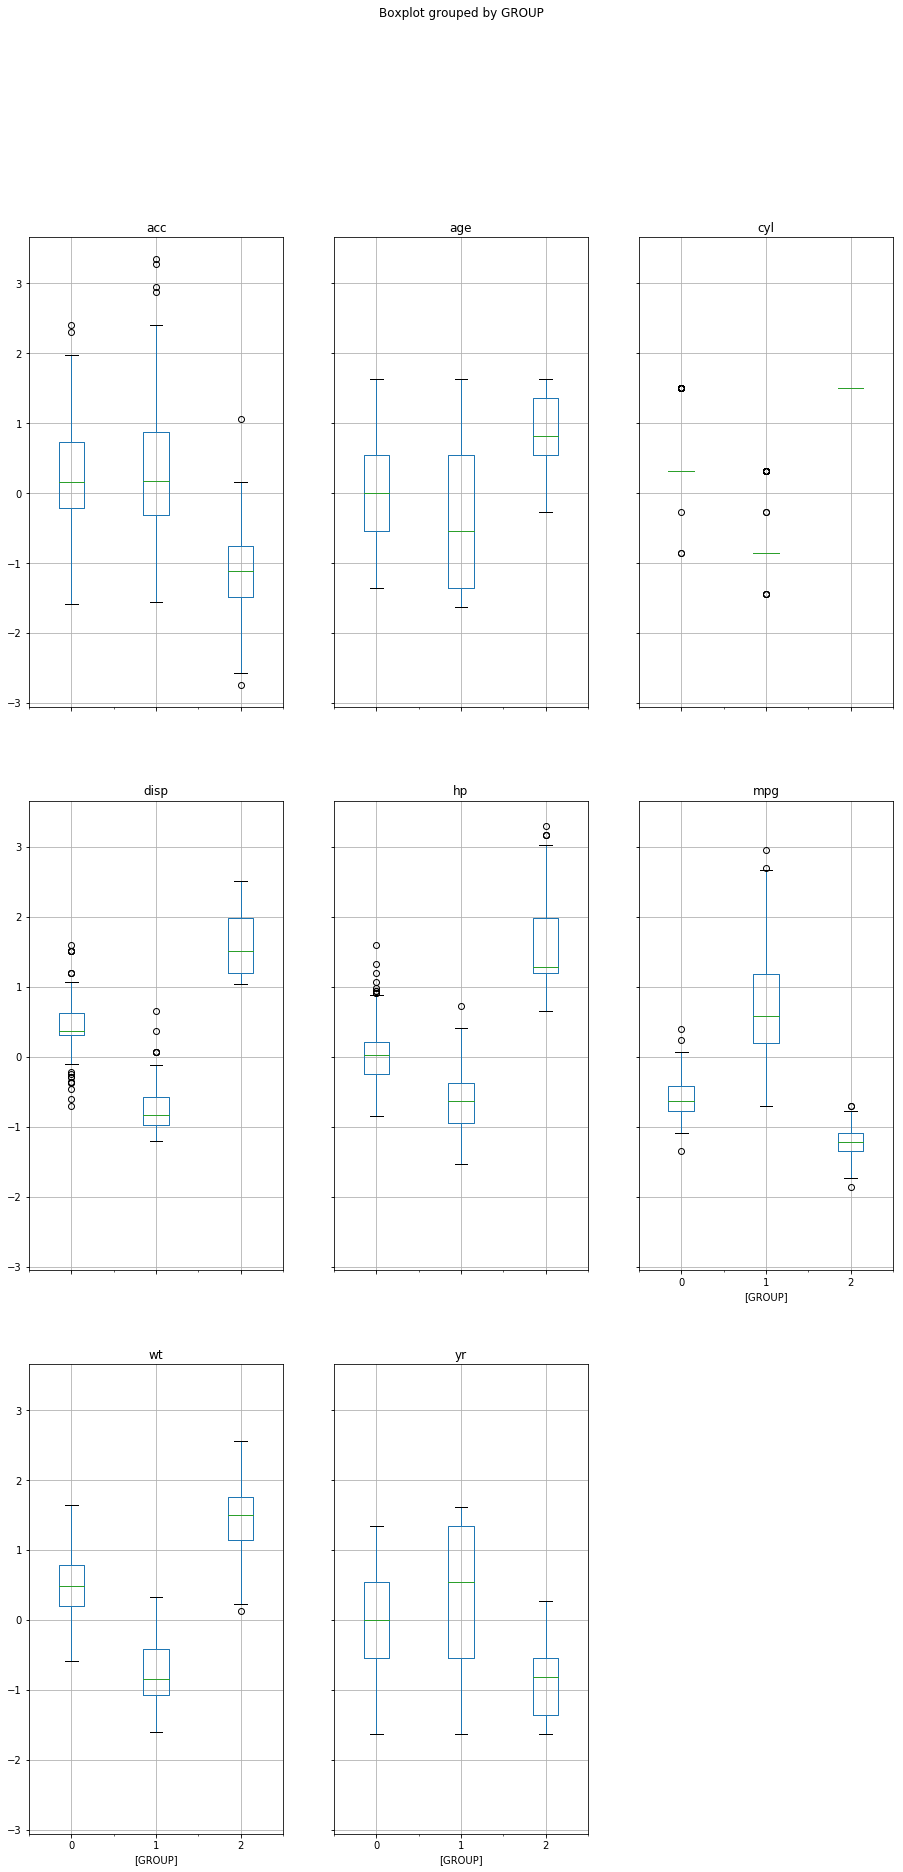

In [175]:
cars_z_2 = cars_z
prediction=kmeans_2.predict(cars_z)
cars_z_2["GROUP"] = prediction
cars_z_2.boxplot(by = 'GROUP',  layout=(4,3), figsize=(15, 40))

<h3> K-means clustering is performed with K- value as 3 which gave the above box plot. Based on the above box plot we can conclude that the clusters seems to overlap. hence we should increase the no of clusters.


In [176]:
kmeans_3 = KMeans(n_clusters=4)
# Fitting the input data
kmeans_3 = kmeans_3.fit(cars_z)
#cluster labels
labels = kmeans_3.labels_
# Centroid values
centroids_3 = kmeans_3.cluster_centers_
# Comparing with scikit-learn centroids
print("Centroid values")
print(centroids_3)


Centroid values
[[-0.81248657 -0.80524031 -0.5873768  -0.80440822  0.3062976  -0.78050568
   0.22776635  0.94680851  0.78050568]
 [ 0.56777933  0.47449027  0.07588559  0.51367793  0.27120661  0.05260004
  -0.6009251   0.03225806 -0.05260004]
 [ 1.49819126  1.54939326  1.62337311  1.4607005  -1.14533608 -0.88527717
  -1.21964536  2.          0.88527717]
 [-0.7521787  -0.72258354 -0.6410551  -0.69595704  0.29813872  1.07833216
   1.02513287  1.         -1.07833216]]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000042945D0CC0>,
      dtype=object)

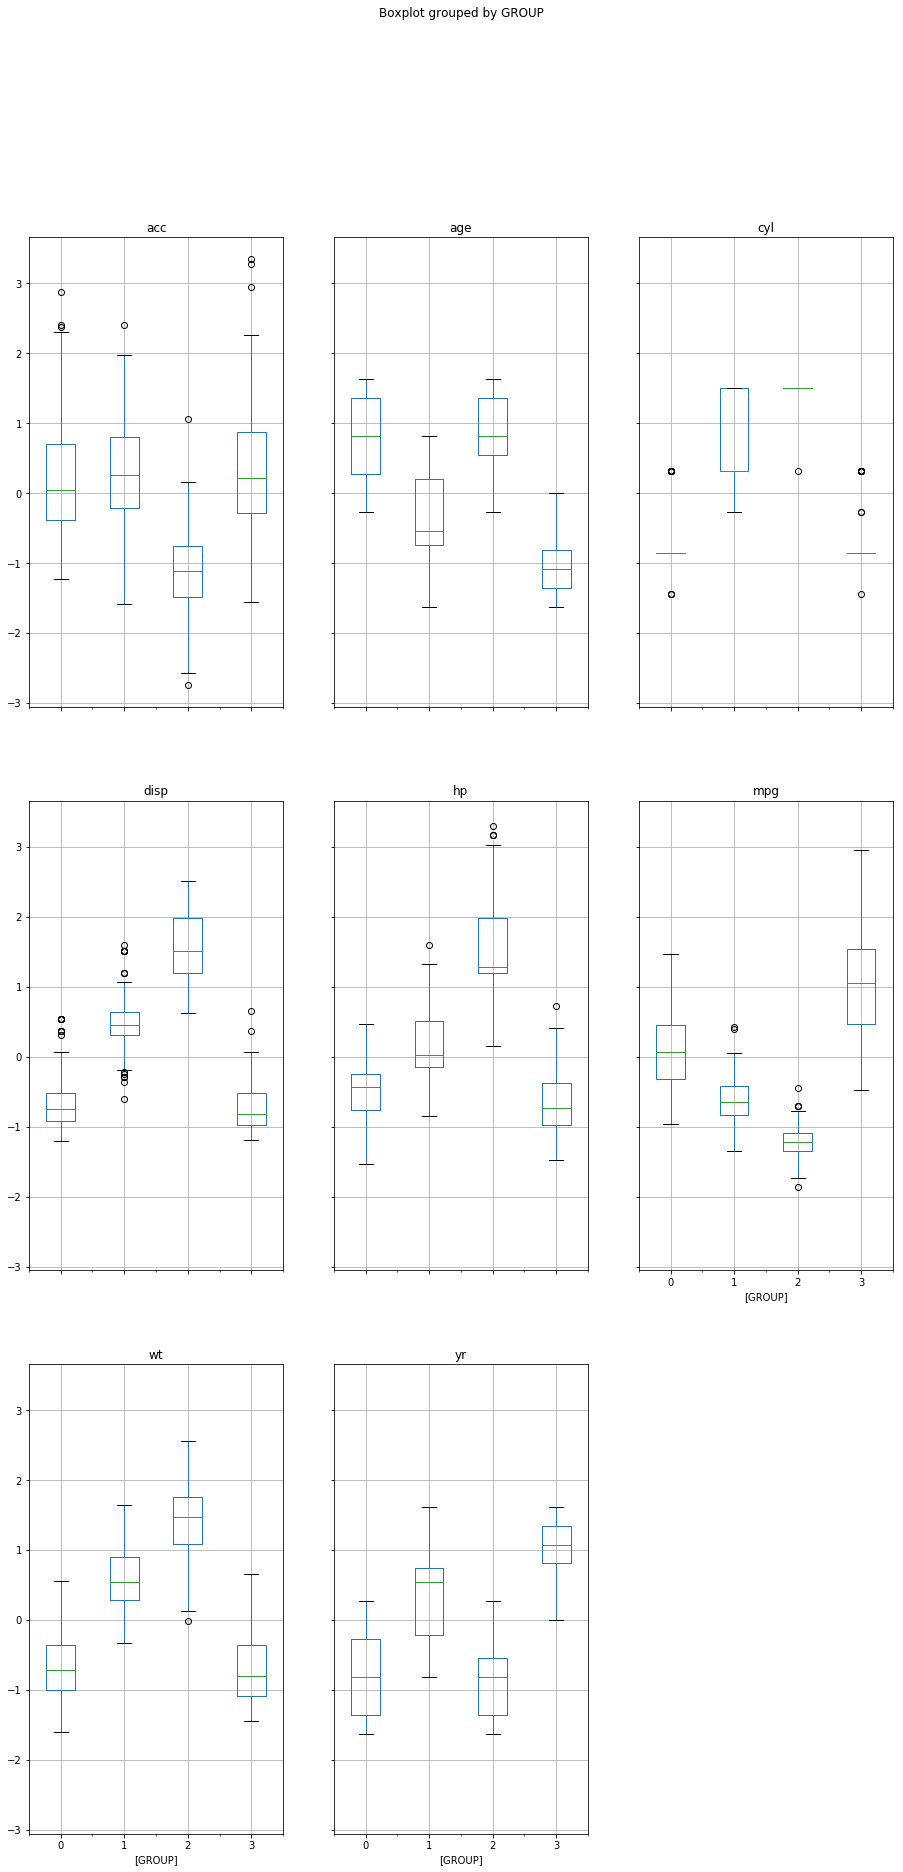

In [181]:
cars_z_3 = cars_z
prediction_3=kmeans_3.predict(cars_z)
cars_z_3["GROUP"] = prediction_3
cars_z_3.boxplot(by = 'GROUP',  layout=(4,3), figsize=(15, 40))

In [178]:
kmeans_4 = KMeans(n_clusters=5)
# Fitting the input data
kmeans_4 = kmeans_4.fit(cars_z)
# Centroid values
centroids_4 = kmeans_4.cluster_centers_
# Comparing with scikit-learn centroids
print("Centroid values")
print(centroids_4)

Centroid values
[[-7.52178702e-01 -7.22583539e-01 -6.41055100e-01 -6.95957044e-01
   2.98138720e-01  1.07833216e+00  1.02513287e+00  3.00000000e+00
  -1.07833216e+00]
 [ 1.46721084e+00  1.25106773e+00  1.07652552e+00  1.23010070e+00
  -7.02150990e-01  2.53810895e-01 -9.23878341e-01  1.52631579e+00
  -2.53810895e-01]
 [ 3.60177207e-01  3.12283209e-01 -1.15335856e-01  3.95315335e-01
   4.67612777e-01 -7.85410080e-02 -5.65353524e-01  1.00000000e+00
   7.85410080e-02]
 [ 1.49819126e+00  1.61748582e+00  1.74250494e+00  1.47043133e+00
  -1.24490538e+00 -1.15688336e+00 -1.26505603e+00  2.00000000e+00
   1.15688336e+00]
 [-8.12486574e-01 -8.05240312e-01 -5.87376799e-01 -8.04408215e-01
   3.06297596e-01 -7.80505682e-01  2.27766346e-01  1.55431223e-15
   7.80505682e-01]]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000004292663B00>,
      dtype=object)

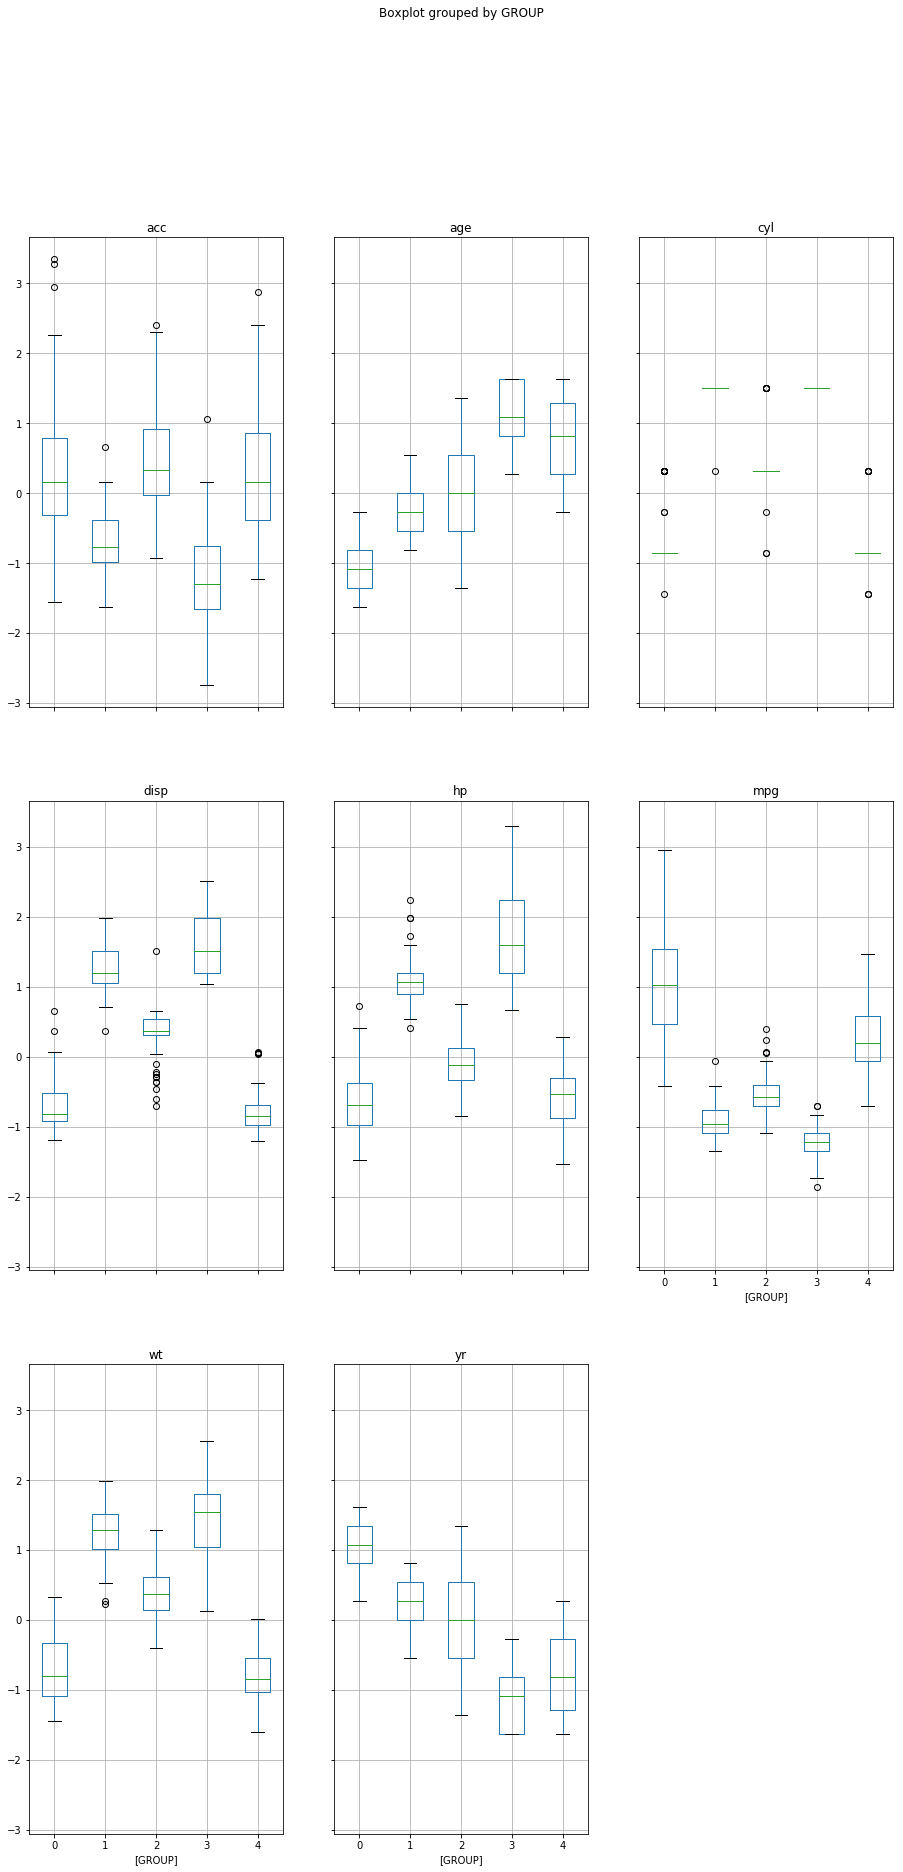

In [179]:
cars_z_4 = cars_z
prediction_4=kmeans_4.predict(cars_z)
cars_z_4["GROUP"] = prediction_4
cars_z_4.boxplot(by = 'GROUP',  layout=(4,3), figsize=(15, 40))

In [180]:
from collections import Counter, defaultdict
print (Counter(labels))

Counter({3: 130, 0: 94, 1: 93, 2: 81})


<h3>  Based on the above three clustering done with K calue as 3, 4 , 5 . We can see that clusters formed with k-value 4 seems to have formed good clusters wihtout much overlapping. and the size of the clusters formed are also of simliar size as shown above.

<h3> since there are outliers we will treat them with the median values

In [182]:
# Addressing outliers at group level

data = cars_z_3   # lazy to type long names. Renaming it to data. Remember data is not a copy of the dataframe
       
def replace(group):
    median, std = group.median(), group.std()  #Get the median and the standard deviation of every group 
    outliers = (group - median).abs() > 2*std # Subtract median from every member of each group. Take absolute values > 2std
    group[outliers] = group.median()       
    return group

data_corrected = (data.groupby('GROUP').transform(replace)) 
concat_data = data_corrected.join(pd.DataFrame(cars_z_3['GROUP']))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000042964C6358>,
      dtype=object)

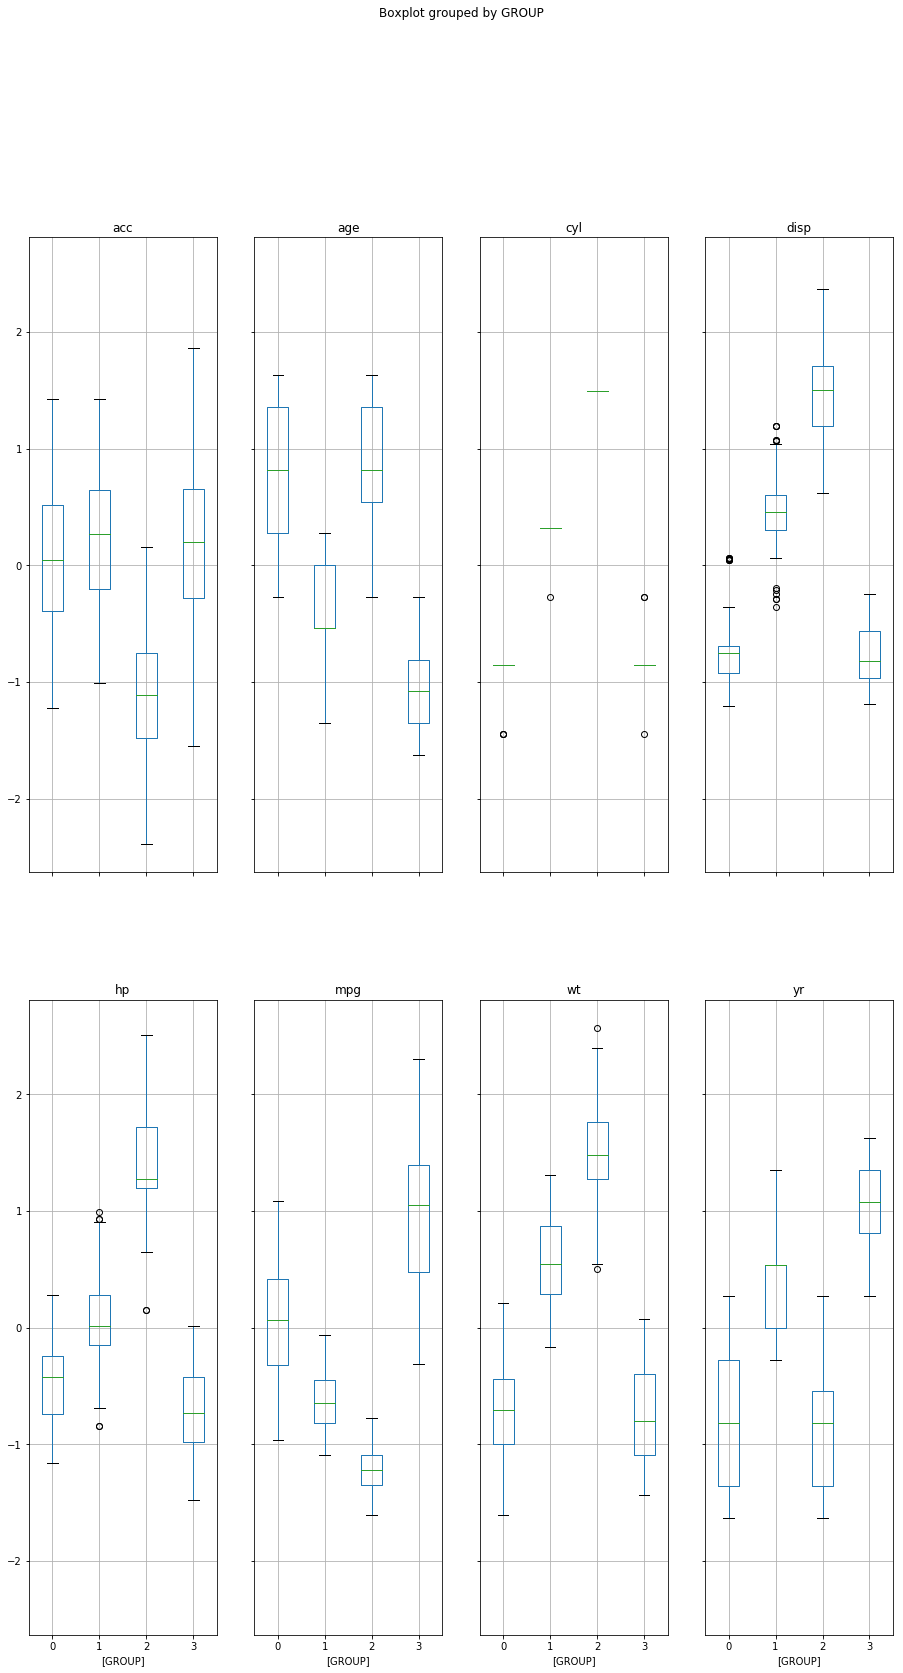

In [183]:
concat_data.boxplot(by = 'GROUP', layout=(3,4), figsize=(15, 40))

<h3> There still seems to be some outliers in displacement,horsepower and Mpg which is created because of the new median value, which will be ignored since it lies very close to the outliers.

In [184]:
cars_edited['GROUP'] = concat_data['GROUP']

In [185]:
cars_edited

,cyl,disp,hp,wt,acc,yr,mpg,GROUP,age
0,8,307.0,130,3504,12.0,70,18.0,2,13
1,8,350.0,165,3693,11.5,70,15.0,2,13
2,8,318.0,150,3436,11.0,70,18.0,2,13
3,8,304.0,150,3433,12.0,70,16.0,2,13
4,8,302.0,140,3449,10.5,70,17.0,2,13
5,8,429.0,198,4341,10.0,70,15.0,2,13
6,8,454.0,220,4354,9.0,70,14.0,2,13
7,8,440.0,215,4312,8.5,70,14.0,2,13
8,8,455.0,225,4425,10.0,70,14.0,2,13
9,8,390.0,190,3850,8.5,70,15.0,2,13


<h2> 4. Using linear regression model on different clusters separately and print the coefficients of the models individually 

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics


In [187]:
cars_g = cars_edited.groupby('GROUP')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



 GROUP :  1
Coefficient [ 1.19740223 -0.04464874 -0.07998011 -0.00406998 -0.26019074  0.02883549
 -0.02883549]
Intercept 43.79156314950466
R- Square 0.5345073308500858
RMSE 8.427591758337847

 GROUP :  2
Coefficient [ 0.41448915  0.01030121  0.02978477 -0.0059752   0.48219726  0.32983702
 -0.32983702]
Intercept -0.5776168925016343
R- Square -0.028226977760253513
RMSE 4.039279862047521

 GROUP :  3
Coefficient [ 0.00000000e+00  5.81511723e-04 -4.28207659e-02 -5.32252212e-04
 -5.50090416e-01  5.40315178e-02 -5.40315178e-02]
Intercept 26.645198869322634
R- Square 0.25501246900901997
RMSE 2.8446603883359582

 GROUP :  4
Coefficient [ 1.66423425 -0.06247351 -0.13441572 -0.00420957  0.00437254  0.47862481
 -0.47862481]
Intercept 15.769954710063796
R- Square 0.4462906121484098
RMSE 14.664387005670951


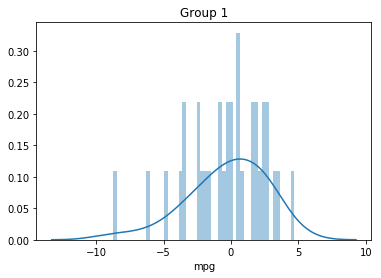

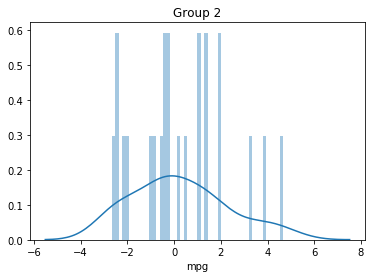

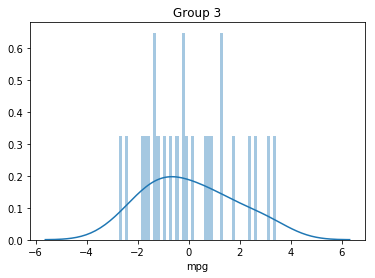

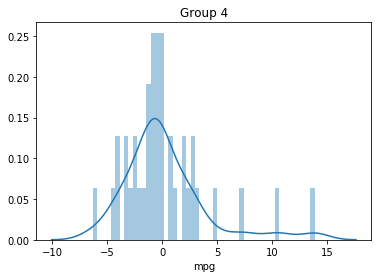

In [212]:
groups = []
Coeff = []
Inter = []
RSq=[]
RMSE=[]

for x in cars_g.groups:
    df = cars_g.get_group(x)
    X = df.drop(['mpg','GROUP'], axis=1)
    y = df['mpg']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=100)
    lm = LinearRegression()
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    
    plt.figure(x)
    plt.title('Group ' + str(x+1))
    sns.distplot((y_test-predictions),bins=50);
    
    print('\n GROUP : ',x+1)
    print('Coefficient',lm.coef_)
    print('Intercept',lm.intercept_)
    print('R- Square', metrics.r2_score(y_test,predictions))
    print('RMSE',metrics.mean_squared_error(y_test, predictions))
    

<h3> Observation : All the four clusters are normally distributed